<a href="https://colab.research.google.com/github/joepaul13/WordleKing/blob/main/WordleKing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
import string
import copy
import re
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
with open('answers.txt') as file:
  possible_answers = file.readlines()
  list_possible_answers = sorted([re.sub(r'[^A-Z]', '', t.upper()) for t in possible_answers[0].split(',')])
  print(len(list_possible_answers), list_possible_answers[:5])

2315 ['ABACK', 'ABASE', 'ABATE', 'ABBEY', 'ABBOT']


In [ ]:
arr_words_5l = np.array([list(w) for w in list_possible_answers])
df_words_5l = pd.DataFrame(data=arr_words_5l, columns=[f'letter_{i+1}' for i in range(5)])
df_words_5l['word'] = list_possible_answers
df_words_5l.head()

,letter_1,letter_2,letter_3,letter_4,letter_5,word
0,A,B,A,C,K,ABACK
1,A,B,A,S,E,ABASE
2,A,B,A,T,E,ABATE
3,A,B,B,E,Y,ABBEY
4,A,B,B,O,T,ABBOT


In [ ]:
test_dict_letter_counts = Counter()
for i in range(5):
   test_dict_letter_counts[i+1] = Counter(df_words_5l[f'letter_{i+1}'])
test_dict_letter_counts[1]

Counter({'A': 141,
         'B': 173,
         'C': 198,
         'D': 111,
         'E': 72,
         'F': 136,
         'G': 115,
         'H': 69,
         'I': 34,
         'J': 20,
         'K': 20,
         'L': 88,
         'M': 107,
         'N': 37,
         'O': 41,
         'P': 142,
         'Q': 23,
         'R': 105,
         'S': 366,
         'T': 149,
         'U': 33,
         'V': 43,
         'W': 83,
         'Y': 6,
         'Z': 3})

In [ ]:
class Game:
  def __init__(self, df_all_5l_words):
    self.possible_letters = list(string.ascii_uppercase)
    self.dict_misplaced_letters = Counter()
    self.df_possible_5l_words = df_all_5l_words.copy(deep = True)
    self.dict_letters = defaultdict(str)
    for i in range(5):
      self.dict_letters[i+1] = None
    self.dict_letter_counts = defaultdict(str)
    for i in range(5):
      self.dict_letter_counts = Counter(df_all_5l_words[f'letter_{i+1}'])

  def calculate_freq_score(self, letters:str) -> int:
    letters = re.sub('^A-Z', '', letters.upper())
    assert len(letters) == 5, 'Word must be 5 characters long'
    score = 0
    for i,l in enumerate(list(letters.upper())):
      score += self.dict_letter_counts[i+1][l]
    return score

  def guess(self):
    for i in range(5):
      self.dict_letter_counts[i+1] = Counter(self.df_possible_5l_words[f'letter_{i+1}'])
    vect_calculate_freq_score = np.vectorize(self.calculate_freq_score)
    self.df_possible_5l_words['freq_score'] = vect_calculate_freq_score(self.df_possible_5l_words['word'])
    self.df_possible_5l_words = self.df_possible_5l_words.sort_values(by='freq_score', ascending=False)
    return self.df_possible_5l_words

  def check_misplaced_letters(self, word: str) -> bool:
    word = re.sub(r'[^A-Z]', '', word.upper())
    assert len(word) == 5, 'Word must be 5 characters long'
    list_word = list(word)
    not_solved = [key for key, value in self.dict_letters.items() if value is None]
    list_word_unsolved = [list_word[i-1] for i in not_solved]
    dict_count_letters = Counter(list_word_unsolved)
    valid = True
    for check_key, check_value in self.dict_misplaced_letters.items():
        if dict_count_letters[check_key] < check_value:
            valid = False    
    return valid


  def update(self, guess: str, results: list):
    guess = re.sub(r'[^A-Z]', '', guess.upper())
    assert len(guess) == 5, 'Guess must be 5 characters long'
    assert len(results) == 5, 'Results list must contain 5 items'
    assert all([n in [0,1,2] for n in results]), 'Results list must only contain ints 0, 1, or 2'
    list_guess = list(guess.upper())
    df_guess_results = pd.DataFrame(data=list(zip(list_guess, results)), columns=['letter', 'result'], index=np.arange(1,6))
    already_solved = [key for key, value in self.dict_letters.items() if value is not None]
    df_corr_answers = df_guess_results.query('result==2')
    if df_corr_answers.shape[0] > 0:
        for idx, row in df_corr_answers.iterrows():
            if idx in already_solved:
                pass
            else:
                corr_letter = row['letter']
                self.dict_letters[idx] = corr_letter
                if corr_letter in self.dict_misplaced_letters.keys():
                    self.dict_misplaced_letters[corr_letter] -= 1
                self.df_possible_5l_words = self.df_possible_5l_words.query(f'letter_{idx}=="{corr_letter}"')
    df_mispl_answers = df_guess_results.query('result==1')
    if df_mispl_answers.shape[0] > 0:
      for idx, row in df_mispl_answers.iterrows():
            mispl_letter = row['letter']
            self.df_possible_5l_words = self.df_possible_5l_words.query(f'letter_{idx}!="{mispl_letter}"')  
      guess_mispl_letters = df_mispl_answers['letter'].values
      dict_guess_mispl_letters = Counter(guess_mispl_letters)
      for key, value in dict_guess_mispl_letters.items():
          self.dict_misplaced_letters[key] = value   
      vect_check_misplaced_letters = np.vectorize(self.check_misplaced_letters)
      self.df_possible_5l_words['valid'] = vect_check_misplaced_letters(self.df_possible_5l_words['word'])
      self.df_possible_5l_words = self.df_possible_5l_words.query('valid == True')
      self.df_possible_5l_words = self.df_possible_5l_words.drop('valid', axis=1)    
    df_wrong_answers = df_guess_results.query('result==0')
    if df_wrong_answers.shape[0] > 0:
        for l in df_wrong_answers['letter'].unique():
            if self.dict_misplaced_letters[l] == 0:
                self.possible_letters.remove(l)
    yet_to_solve = [key for key, value in self.dict_letters.items() if value is None]
    for position in yet_to_solve:
        position_letters = self.df_possible_5l_words[f'letter_{position}']
        position_in_possible_letters = [l in self.possible_letters for l in position_letters]
        self.df_possible_5l_words = self.df_possible_5l_words[position_in_possible_letters].copy(deep=True)

In [ ]:
def play_game(target_word, df_possible_words, debug=False):
  target_word = re.sub(r'[^A-Z]', '', target_word.upper())
  assert len(target_word) == 5, 'target_word must be 5 characters long'
  assert all(df_possible_words.columns == ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']), "Dataframe must have columns ['letter_1', 'letter_2', 'letter_3', 'letter_4', 'letter_5', 'word']"
  
  TestGame = Game(df_possible_words)
  target_letters = list(target_word)
  for guess_turn in range(6):
    guess_word = TestGame.guess().iloc[0]['word']
    guess_letters = list(guess_word)
    dict_results = defaultdict(str)
    for i in range(5):
      dict_results[i] = None

    for pos, guess_letter in enumerate(guess_letters):
      if guess_letter == target_letters[pos]:
        dict_results[pos] = 2
    remaining_pos = [key for key, value in dict_results.items() if value is None]
    if len(remaining_pos) == 0:
      results = [2,2,2,2,2]
    else:
      remaining_guess_letters = [[guess_letters[i], i] for i in remaining_pos]
      remaining_target_letters = [target_letters[i] for i in remaining_pos]
      dict_target_letter_count = Counter(remaining_target_letters)
      for [letter, pos] in remaining_guess_letters:
        if dict_target_letter_count[letter] > 0:
          dict_target_letter_count[letter] -= 1
          dict_results[pos] = 1
        else:
          dict_results[pos] = 0
      results = list(dict_results.values())
    if debug:
      print(f'Turn {guess_turn+1}, guess {guess_word}, results {results}\n')
    if np.sum(results) == 10:
      if debug:
        print('Game won!')
      else:
        return (target_word, guess_turn+1)
      break
    if guess_turn == 5:
      if debug:
        print('Unsolved!')
      else:
        return (target_word, 7)
    TestGame.update(guess_word, results)

In [ ]:
rand_keys = np.random.randint(low=0, high=len(list_possible_answers), size=2)
rand_words = [list_possible_answers[k] for k in rand_keys]

for i, word in enumerate(rand_words):
    print(f'**GAME {i}: target {word}**')
    play_game(word, df_words_5l, debug=True)
    print('\n')


**GAME 0: target CHAFF**
Turn 1, guess SLATE, results [0, 0, 2, 0, 0]

Turn 2, guess CRACK, results [2, 0, 2, 0, 0]

Turn 3, guess CHAIN, results [2, 2, 2, 0, 0]

Turn 4, guess CHAMP, results [2, 2, 2, 0, 0]

Turn 5, guess CHAFF, results [2, 2, 2, 2, 2]

Game won!


**GAME 1: target MAKER**
Turn 1, guess SLATE, results [0, 0, 1, 0, 1]

Turn 2, guess RACER, results [0, 2, 0, 2, 2]

Turn 3, guess WAGER, results [0, 2, 0, 2, 2]

Turn 4, guess PAYER, results [0, 2, 0, 2, 2]

Turn 5, guess BAKER, results [0, 2, 2, 2, 2]

Turn 6, guess MAKER, results [2, 2, 2, 2, 2]

Game won!




In [ ]:
all_results = []
for answer in tqdm(list_possible_answers):
    all_results.append(play_game(answer, df_words_5l, debug=False))
all_results[:10]

  3%|▎         | 79/2315 [00:06<02:48, 13.25it/s]<ipython-input-5-c7b3ae1debe2>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_possible_5l_words['valid'] = vect_check_misplaced_letters(self.df_possible_5l_words['word'])
  6%|▋         | 146/2315 [00:10<02:11, 16.45it/s]<ipython-input-5-c7b3ae1debe2>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_possible_5l_words['valid'] = vect_check_misplaced_letters(self.df_possible_5l_words['word'])
 52%|█████▏    | 1194/2315 [01:10<01:06, 16.89it/

[('ABACK', 5),
 ('ABASE', 4),
 ('ABATE', 3),
 ('ABBEY', 4),
 ('ABBOT', 4),
 ('ABHOR', 4),
 ('ABIDE', 4),
 ('ABLED', 4),
 ('ABODE', 3),
 ('ABORT', 4)]

Average turns taken: 3.67
Unsolved words: 13


<Axes: xlabel='turns_taken', ylabel='Count'>

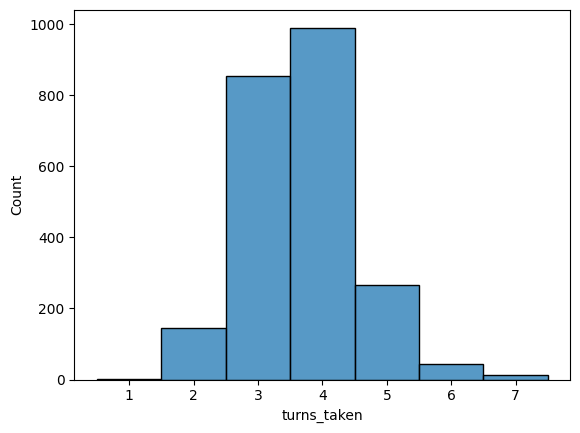

In [ ]:
df_all_results = pd.DataFrame(data=all_results,
                              columns=['word', 'turns_taken'])
print('Average turns taken: {:.2f}'.format(df_all_results['turns_taken'].mean()),
      'Unsolved words: {}'.format(df_all_results.query('turns_taken==7').shape[0]),
      sep='\n')
sns.histplot(data=df_all_results['turns_taken'],
             discrete=True)

In [ ]:
unsolved_words = df_all_results.query('turns_taken==7')['word'].sample(3, random_state=1)

for word in unsolved_words:
    print(f'**Target {word}**')
    play_game(word, df_words_5l, debug=True)
    print('\n')

**Target HOMER**
Turn 1, guess SLATE, results [0, 0, 0, 0, 1]

Turn 2, guess FEVER, results [0, 0, 0, 2, 2]

Turn 3, guess CIDER, results [0, 0, 0, 2, 2]

Turn 4, guess POWER, results [0, 2, 0, 2, 2]

Turn 5, guess ROGER, results [0, 2, 0, 2, 2]

Turn 6, guess BOXER, results [0, 2, 0, 2, 2]

Unsolved!


**Target HOUND**
Turn 1, guess SLATE, results [0, 0, 0, 0, 0]

Turn 2, guess CRONY, results [0, 0, 1, 2, 0]

Turn 3, guess POUND, results [0, 2, 2, 2, 2]

Turn 4, guess BOUND, results [0, 2, 2, 2, 2]

Turn 5, guess FOUND, results [0, 2, 2, 2, 2]

Turn 6, guess WOUND, results [0, 2, 2, 2, 2]

Unsolved!


**Target JOKER**
Turn 1, guess SLATE, results [0, 0, 0, 0, 1]

Turn 2, guess FEVER, results [0, 0, 0, 2, 2]

Turn 3, guess CIDER, results [0, 0, 0, 2, 2]

Turn 4, guess POWER, results [0, 2, 0, 2, 2]

Turn 5, guess ROGER, results [0, 2, 0, 2, 2]

Turn 6, guess BOXER, results [0, 2, 0, 2, 2]

Unsolved!


